In [2]:
from scipy.integrate import odeint
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import numpy as np
#import jax.numpy as jnp

In [3]:
#set up grid
nx,ny = 500,500
x = np.linspace(0, nx, nx + 1)
y = np.linspace(0, ny, ny + 1)
X, Y = np.meshgrid(x, y)
L = 1
delta = L/nx


#charge density
rho = np.zeros([nx+1,ny+1],float)
rho[40:60,:] = 1e12* (1.6e-19) #C/m^2
rho[40,:] = 1e12* (1.6e-19) + 1e-7 *np.sin(1*x)
epsilon = 8.85e-12 #F/m

#time steps
steps = 10
dt = 1e-8

#magnetic field
B = 0.1 #Tesla

In [4]:
print (X.shape)

(501, 501)


In [5]:
# trial 1: not including periodic side boundary 
#create the A matrix
def create_A(nx,ny):
    A = np.zeros(((nx-1)*(ny-1),(nx-1)*(ny-1)),float)
    np.fill_diagonal(A,-4)
    np.fill_diagonal(A[:-1,1:],1)
    np.fill_diagonal(A[1:,:-1],1)

    # fill the identity matrix after first 100 rows
    # fill the identity matrix after first 100 columns
    np.fill_diagonal(A[nx-1:,:-(nx-1)],1)
    np.fill_diagonal(A[:-(nx-1),nx-1:],1)

    # fill 0s for the corners of T
    for i in range (1,(nx-1)*(nx-1)):
        for j in range (1,(ny-1)*(ny-1)):
            if (i)%(nx-1) == 0 and (j+1)%(ny-1) == 0:
                A[i,j] = 0
            if (i+1)%(nx-1) == 0 and (j)%(ny-1) == 0:
                A[i,j] = 0

    return A

def create_sparse_tridiagonal(nx, ny):
    num_diag = (nx-1)*(nx-1)
    diag = np.full(num_diag, -4)
    lower = np.full((num_diag-1),1)
    upper = np.full((num_diag-1),1)
    identity = np.full(num_diag-(nx-1),1)

    lower[nx-2::nx-1] = 0
    upper[nx-2::nx-1] = 0


    diagonal = [diag,lower,upper,identity,identity]
    offsets = [0,-1,1,-(nx-1),(nx-1)]

    return diags(diagonal, offsets, shape =(num_diag, num_diag), format= 'csr')
  #  return diags(diagonal, offsets, shape =(num_diag, num_diag)).toarray()

 #construct boundary vector B
def create_B():
    lil_B1 = np.zeros(((nx-1)*(ny-1),1),float)
    lil_B2 = np.zeros(((nx-1)*(ny-1),1),float)
    f = rho[1:nx,1:ny].reshape((nx-1)*(ny-1),1)*delta**2/epsilon

    lil_B1[0:nx-1] = -rho[1:ny,0].reshape(nx-1,1)
    lil_B1[(nx-1)*(ny-1)-(nx-1):(nx-1)*(ny-1)] = -rho[1:ny,ny].reshape(nx-1,1)

    lil_B2[0:(nx-1)*(ny-1):(ny-1)] = -rho[1:nx,0].reshape(nx-1,1)
    lil_B2[ny-2:(nx-1)*(ny-1):(ny-1)] = -rho[1:nx,ny].reshape(nx-1,1)

    return lil_B1+lil_B2+f

#hmm if its wrapped around, then left side = right side
#so we only need to solve one side and copy the values to the other side


def solve_poisson(rho):
    A = create_sparse_tridiagonal(nx,ny)
    B = create_B()
    rho_interior = rho[1:nx,1:ny].reshape((nx-1)*(ny-1),1)
    rho_interior = spsolve(A,B)
    rho[1:nx,1:ny] = rho_interior.reshape(nx-1,ny-1)
    #rho = side_rho_1(rho)
    return rho



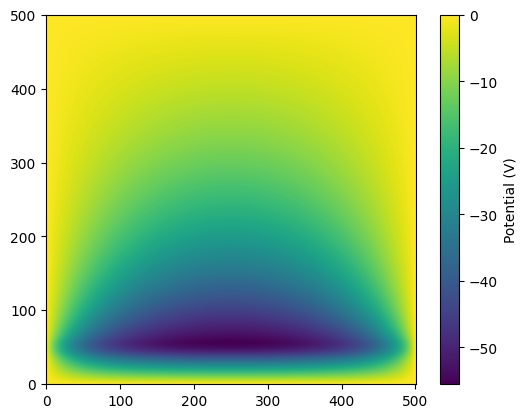

In [6]:
rho = np.zeros([nx+1,ny+1],float)
rho[40:60,:] = 1e12* (1.6e-19) #C/m^2
rho_interior = solve_poisson(rho)
plt.imshow(rho_interior, origin = 'lower')
plt.colorbar(label="Potential (V)",shrink=1)


In [7]:
# trial 2: including periodic side boundary
def create_sparse_tridiagonal_1(nx, ny):
    num_diag = (nx+1)*(ny-1)
    diag = np.full(num_diag, -4)
    lower = np.full((num_diag-1),1)
    upper = np.full((num_diag-1),1)
    identity = np.full(num_diag-(nx-1),1)
    side = np.full(ny-1,1)

    lower[nx-2::nx-1] = 0
    upper[nx-2::nx-1] = 0


    diagonal = [diag,lower,upper,identity,identity,side,side]
    offsets = [0,-1,1,-(nx-1),(nx-1),-nx*(ny-1),nx*(ny-1)]

    return diags(diagonal, offsets, shape =(num_diag, num_diag), format= 'csr')

#construct boundary vector B
def create_B_1(rho):
    lil_B2 = np.zeros(((nx+1)*(ny-1),1),float)
    f = rho[1:nx,0:ny+1].reshape((nx+1)*(ny-1),1,order = 'F')*delta**2/epsilon

    lil_B2[0:(nx+1)*(ny-1):(ny-1)] = -rho[0,0:nx+1].reshape((ny+1),1)
    lil_B2[ny-2:(nx+1)*(ny-1):(ny-1)] = -rho[ny,0:nx+1].reshape(ny+1,1)

    return lil_B2+f

def solve_poisson_1(rho):
    phi = np.zeros([nx+1,ny+1],float)
    A = create_sparse_tridiagonal_1(nx,ny)
    B = create_B_1(rho)
    phi_flat = phi.flatten(order= 'F') 
    phi_flat= spsolve(A,B)
    phi[1:nx,0:ny+1] = phi_flat.reshape(nx-1,ny+1,order = 'F')
    return phi

In [8]:
def electric_field(phi):
    Ex = np.zeros([nx+1, ny+1], float)
    Ey = np.zeros([nx+1, ny+1], float)

    for i in range(1, nx):
        for j in range(1, ny):
            #row of an array is 'i' (y-direction)
            #column of an array is 'j' (x-direction)
            Ex[i, j] = -(phi[i, j + 1] - phi[i, j - 1]) / (2*delta)
            Ey[i, j] = -(phi[i + 1, j] - phi[i - 1, j]) / (2*delta)


    plt.show()
    return Ex, Ey

def velocity(Ex, Ey, B):
    vx = np.zeros([nx+1, ny+1], float)
    vy = np.zeros([nx+1, ny+1], float)

    for i in range(1, nx):
        for j in range(1, ny):
            vx[i, j] = Ey[i, j] / B
            vy[i, j] = -Ex[i, j] / B

    return vx, vy

#forward Euler method
def forward_euler_charge_density(rho, vx, vy, dt):
    rho_new_time = rho.copy()
    for n in range(1):
        for i in range(1, nx):
            for j in range(1, ny):
                # not sure vx and vy should be at i,j or i+1,j or i-1,j
                #rho_new_time[i, j] = rho[i, j] - dt *( (rho[i +1, j]  - rho[i - 1, j] )* vx[i, j] /  (2*delta) +
                #                                    (rho[i, j+1]  - rho[i, j - 1] ) * vy[i, j]/ (2*delta)  )
                rho_new_time[i, j] = rho[i, j] - dt *( (rho[i, j]  - rho[i - 1, j] )* vx[i, j] /  (1*delta) +
                                                   (rho[i, j]  - rho[i, j - 1] ) * vy[i, j]/ (1*delta)  )
                #rho_new_time[i, j] = rho[i, j] - dt * ( (rho[i , j] * vx[i, j] - rho[i - 1, j] * vx[i - 1, j]) /  delta +
                #                                    (rho[i, j] * vy[i, j] - rho[i, j - 1] * vy[i, j - 1]) / delta )
        rho = rho_new_time.copy()
    return rho_new_time

# only works for position-independent vx, vy
#https://github.com/Peiyi-wisc/Magnetized_VP_control/blob/main/VP-2D2D-external-magnetic.ipynb
def fast_fourier_transform_rho(rho,vx,vy,dt):
    rho_hat = np.fft.fft2(rho, axes=(0, 1))
    kx,ky = np.fft.fftfreq(nx+1, d=delta)*2*np.pi , np.fft.fftfreq(ny+1, d=delta)*2*np.pi
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    drho_dx_fft = (1j *KX)*rho_hat
    drho_dy_fft = (1j*KY)*rho_hat

    
    drho_dx = np.fft.ifft2(drho_dx_fft)
    drho_dy = np.fft.ifft2(drho_dy_fft)

    
    drho_dx_1 = np.real(drho_dx)
    drho_dy_1 = np.real(drho_dy)
    rho_update = rho - dt*(vx*drho_dx_1 + vy*drho_dy_1)
    
    #rho_hat_new = np.exp(-1j * (KX * vx + KY * vy) * dt)* rho_hat
    #rho_ift = np.fft.ifft2(rho_hat_new, axes=(0, 1))
    #rho_update =np.real(rho_ift)
    return rho_update


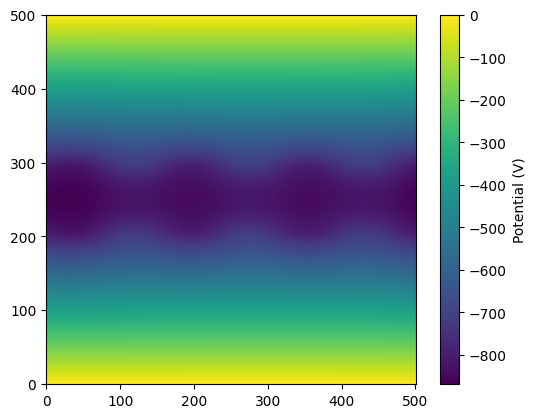

In [9]:
# solve Poisson equation with Matrix Inversion
rho = np.zeros([nx+1,ny+1],float)
rho[200:300,:] = 1e12* (1.6e-19) #C/m^2
rho[290:300,:] = 1e12* (1.6e-19) + 8e-7 *np.sin(0.04*x)
rho[200:210,:] = 1e12* (1.6e-19) + 8e-7 *np.sin(0.04*x)

plt.imshow(rho, origin = 'lower')

phi = solve_poisson_1(rho)
plt.imshow(phi, origin = 'lower')
plt.colorbar(label="Potential (V)",shrink=1)
#ax.streamplot(X, Y, Ex, Ey, color="white", linewidth=1, cmap=plt.cm.inferno,
#              density=1.5, arrowstyle='->', arrowsize=1.5)


# not sure if this is correct: using ODE solver to solve charge density
def charge_density_ode(time_span, rho, vx, vy):
    '''
    rho= rho.reshape((nx+1, ny+1))
    dndt = np.zeros_like(rho)
    #dndt[0, :] = 0
    #dndt[nx, :] = 0
       
    for i in range(1, nx):
        for j in range(1, ny):
            dndt[i, j] = - ( (rho[i + 1, j] * vx[i + 1, j] - rho[i - 1, j] * vx[i - 1, j]) / (2 * delta) +
                             (rho[i, j + 1] * vy[i, j + 1] - rho[i, j - 1] * vy[i, j - 1]) / (2 * delta) )
    '''
    rho= rho.reshape((nx+1, ny+1))
    drho_dx_fft,drho_dy_fft = fast_fourier_transform_rho(rho,vx,vy,dt)
    dndt = np.zeros_like(rho)
    
    dndt_hat = - drho_dx_fft * vx -  drho_dy_fft * vy
    
    return dndt_hat.flatten()

def solve_rho_ode(vx,vy,rho):
    #vx, vy = velocity(Ex, Ey, B)
    time_span = (0.0, 0.01)
    time_intervals = np.linspace(0.0, 0.01,20)
    rho_0 = rho.flatten()
    sol = solve_ivp(charge_density_ode, time_span, rho_0, method='RK45', t_eval=time_intervals, args=(vx, vy))
    rho_new_fft = sol.y[:,0].reshape(nx+1, ny+1)
    rho_new = np.real(np.fft.ifft2(rho_new_fft))
    return rho_new



Ex, Ey = electric_field(phi)
vx, vy = velocity(Ex, Ey, B)
#plt.imshow(solve_rho_ode(vx,vy,rho), origin = 'lower')



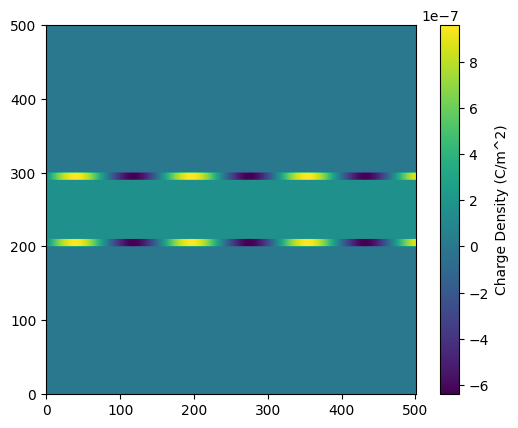

In [10]:
plt.imshow(rho, origin = 'lower')
plt.colorbar(label="Charge Density (C/m^2)",shrink=1)
rho_new = forward_euler_charge_density(rho,vx,vy,dt)


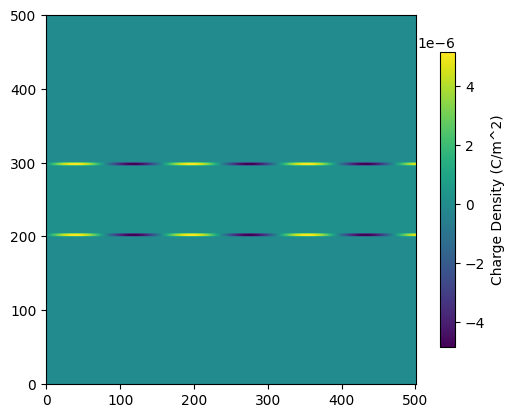

Total charge = 0.008621958027784486
Time step 0


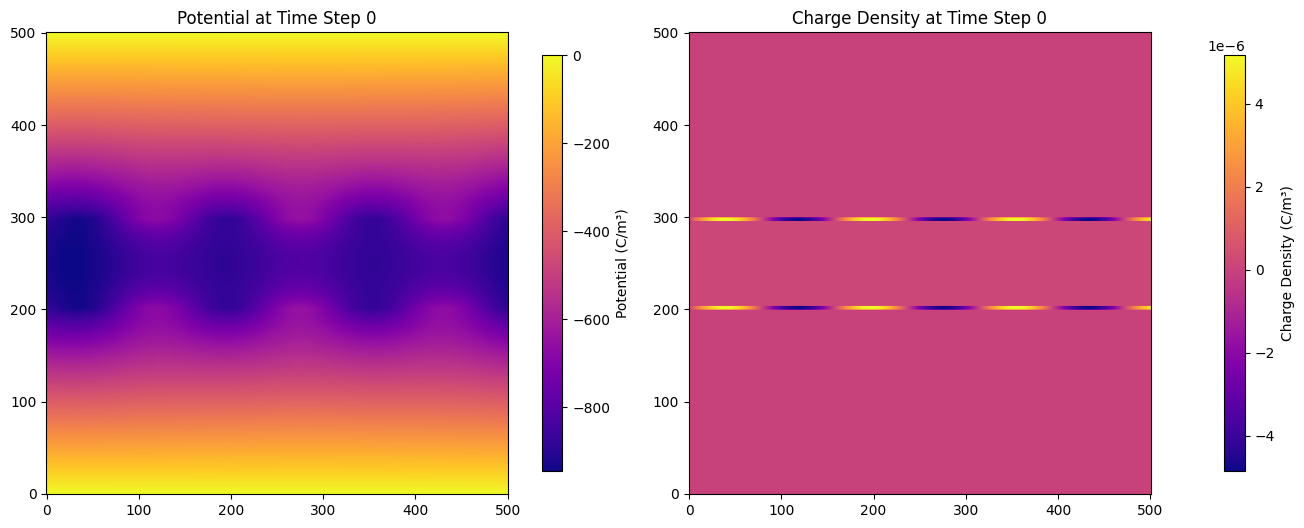

<Figure size 640x480 with 0 Axes>

Total charge = 0.008617818366622428
Total charge = 0.00861367893238065
Total charge = 0.00860953972222218
Total charge = 0.008605400733310948
Total charge = 0.00860126196281172
Total charge = 0.008597123407890078
Total charge = 0.008592985065712358
Total charge = 0.008588846933445617
Total charge = 0.008584709008257575
Total charge = 0.00858057128731659
Total charge = 0.00857643376779159
Total charge = 0.008572296446852059
Total charge = 0.008568159321667955
Total charge = 0.008564022389409705
Total charge = 0.008559885647248128
Total charge = 0.008555749092354415
Total charge = 0.008551612721900073
Total charge = 0.008547476533056878
Total charge = 0.00854334052299684
Total charge = 0.008539204688892157
Total charge = 0.00853506902791517
Total charge = 0.008530933537238312
Total charge = 0.008526798214034079
Total charge = 0.008522663055474975
Total charge = 0.00851852805873347
Total charge = 0.008514393220981957
Total charge = 0.008510258539392712
Total charge = 0.008506124011137846


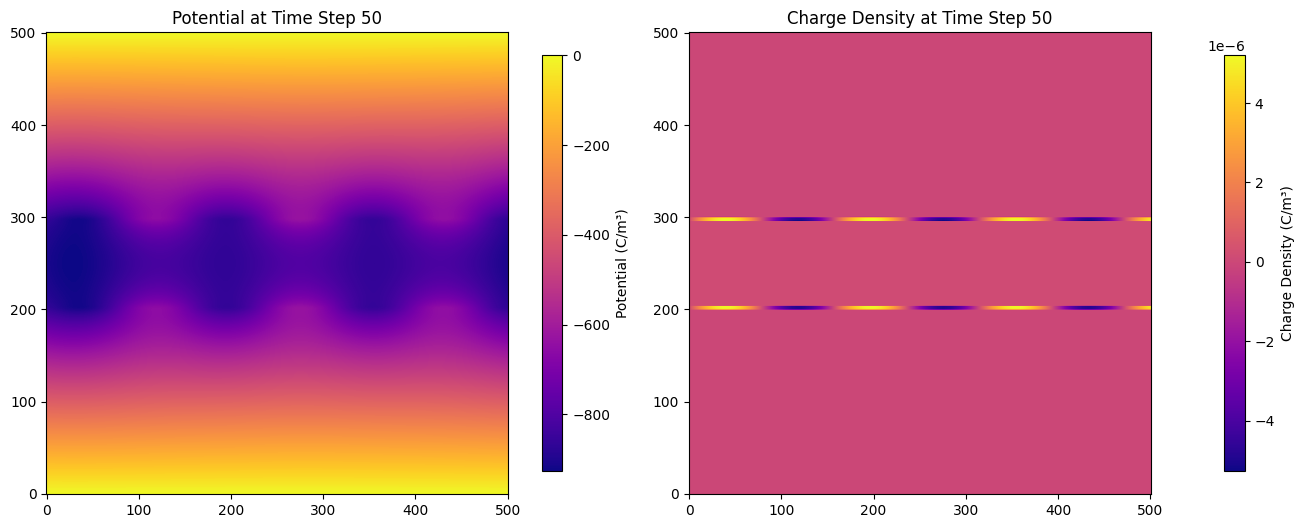

<Figure size 640x480 with 0 Axes>

Total charge = 0.008411065671462365
Total charge = 0.008406933973677571
Total charge = 0.00840280235834971
Total charge = 0.008398670822631411
Total charge = 0.008394539363673978
Total charge = 0.008390407978627334
Total charge = 0.008386276664639989
Total charge = 0.00838214541885899
Total charge = 0.00837801423842988
Total charge = 0.008373883120496658
Total charge = 0.008369752062201731
Total charge = 0.008365621060685878
Total charge = 0.008361490113088198
Total charge = 0.008357359216546074
Total charge = 0.00835322836819513
Total charge = 0.008349097565169184
Total charge = 0.00834496680460021
Total charge = 0.008340836083618292
Total charge = 0.008336705399351583
Total charge = 0.008332574748926257
Total charge = 0.008328444129466477
Total charge = 0.008324313538094343
Total charge = 0.008320182971929848
Total charge = 0.008316052428090847
Total charge = 0.008311921903693002
Total charge = 0.008307791395849744
Total charge = 0.008303660901672233
Total charge = 0.0082995304182693

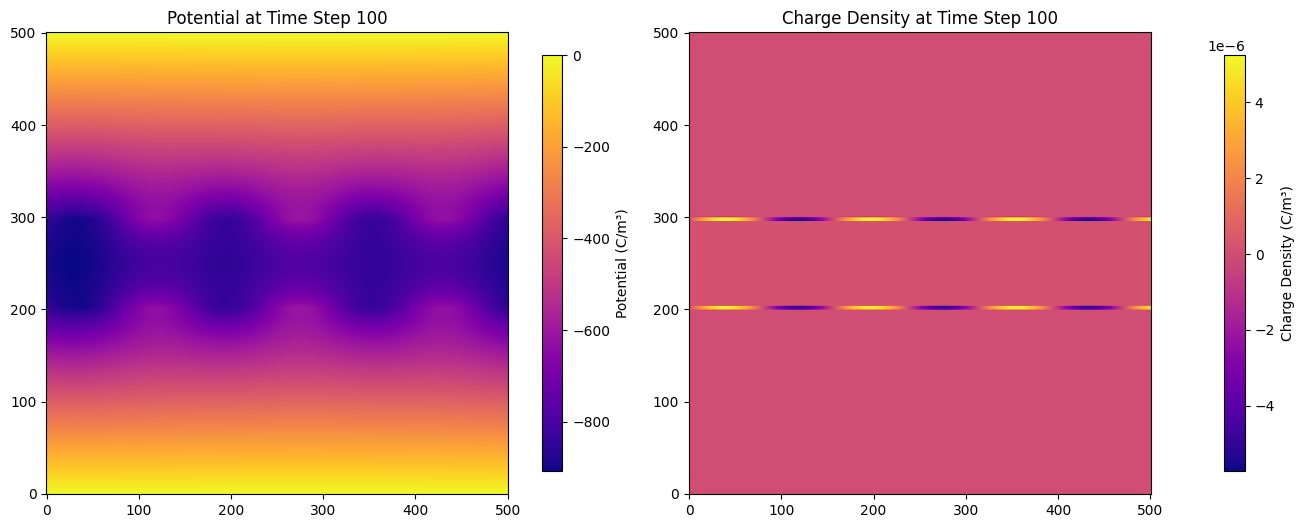

<Figure size 640x480 with 0 Axes>

Total charge = 0.008204525586044994
Total charge = 0.008200394487112517
Total charge = 0.008196263325797957
Total charge = 0.008192132099134943
Total charge = 0.008188000804153644
Total charge = 0.00818386943788071
Total charge = 0.008179737997339245
Total charge = 0.008175606479548748
Total charge = 0.008171474881525082
Total charge = 0.00816734320028043
Total charge = 0.008163211432823246
Total charge = 0.00815907957615822
Total charge = 0.008154947627286229
Total charge = 0.008150815583204301
Total charge = 0.008146683440905564
Total charge = 0.00814255119737921
Total charge = 0.008138418849610448
Total charge = 0.008134286394580463
Total charge = 0.008130153829266374
Total charge = 0.008126021150641195
Total charge = 0.008121888355673778
Total charge = 0.008117755441328787
Total charge = 0.008113622404566645
Total charge = 0.008109489242343495
Total charge = 0.00810535595161116
Total charge = 0.008101222529317087
Total charge = 0.008097088972404323
Total charge = 0.0080929552778114

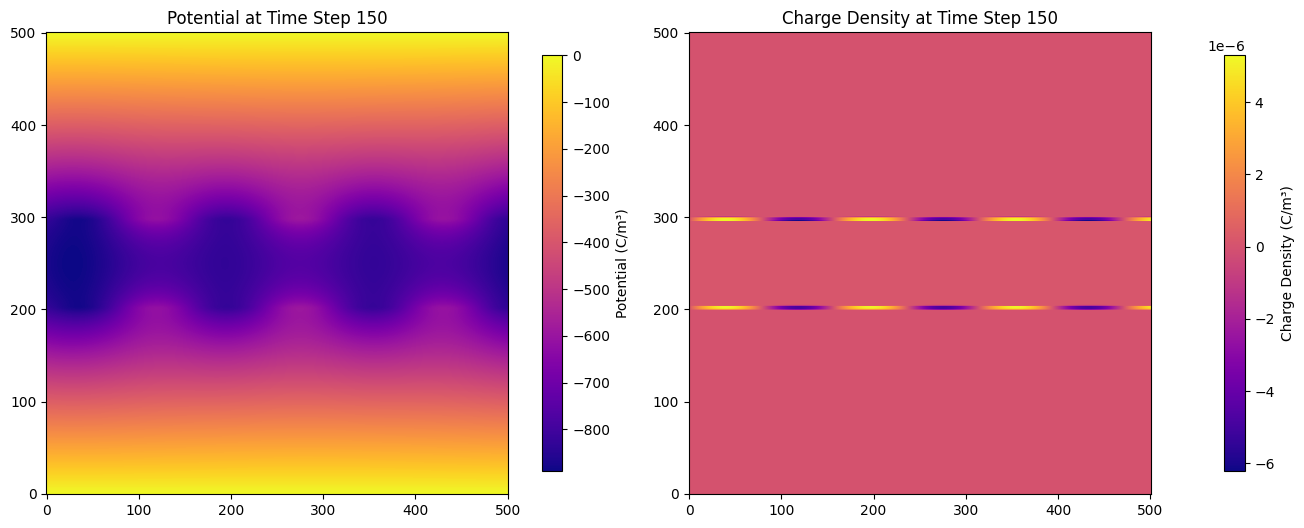

<Figure size 640x480 with 0 Axes>

Total charge = 0.007997835191201305
Total charge = 0.007993697261533967
Total charge = 0.00798955911607867
Total charge = 0.00798542075164315
Total charge = 0.007981282165029538
Total charge = 0.0079771433530343
Total charge = 0.007973004312448202
Total charge = 0.007968865040056262
Total charge = 0.007964725532637718
Total charge = 0.007960585786965962
Total charge = 0.007956445799808528
Total charge = 0.007952305567927016
Total charge = 0.007948165088077074
Total charge = 0.007944024357008337
Total charge = 0.007939883371464401
Total charge = 0.007935742128182759
Total charge = 0.007931600623894775
Total charge = 0.007927458855325628
Total charge = 0.007923316819194278
Total charge = 0.007919174512213419
Total charge = 0.007915031931089427
Total charge = 0.007910889072522334
Total charge = 0.007906745933205771
Total charge = 0.007902602509826925
Total charge = 0.0078984587990665
Total charge = 0.007894314797598669
Total charge = 0.007890170502091037
Total charge = 0.00788602590920459

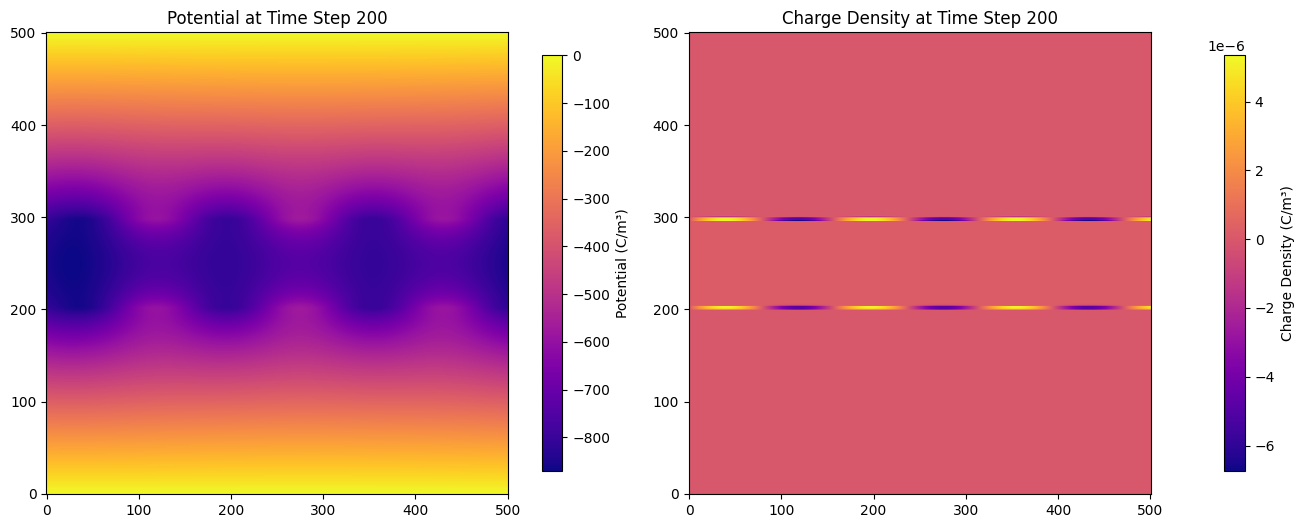

<Figure size 640x480 with 0 Axes>

Total charge = 0.007790610414080178
Total charge = 0.007786457664425991
Total charge = 0.0077823045316389484
Total charge = 0.007778151012192582
Total charge = 0.007773997102552617
Total charge = 0.00776984279917693
Total charge = 0.0077656880985155
Total charge = 0.007761532997010368
Total charge = 0.00775737749109559
Total charge = 0.007753221577197196
Total charge = 0.0077490652517331355
Total charge = 0.007744908511113249
Total charge = 0.00774075135173921
Total charge = 0.007736593770004485
Total charge = 0.007732435762294288
Total charge = 0.0077282773249855415
Total charge = 0.007724118454446822
Total charge = 0.007719959147038321
Total charge = 0.0077157993991118015
Total charge = 0.007711639207010551
Total charge = 0.007707478567069335
Total charge = 0.007703317475614356
Total charge = 0.007699155928963207
Total charge = 0.007694993923424824
Total charge = 0.007690831455299448
Total charge = 0.007686668520878571
Total charge = 0.007682505116444899
Total charge = 0.007678341238

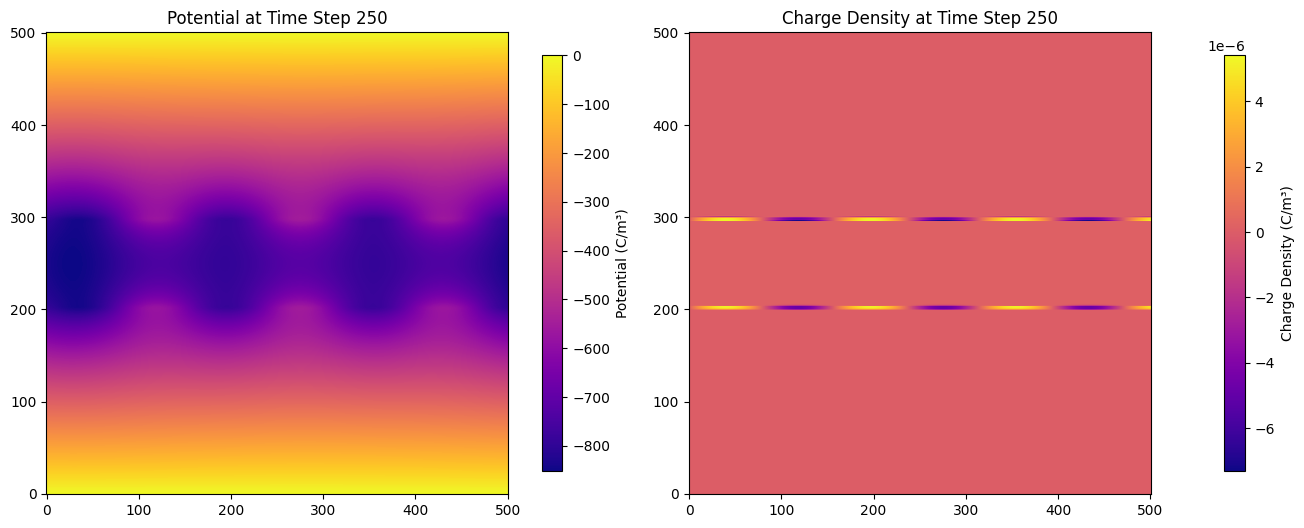

<Figure size 640x480 with 0 Axes>

Total charge = 0.007582432582552096
Total charge = 0.00757825619304621
Total charge = 0.007574079233645058
Total charge = 0.007569901700376961
Total charge = 0.007565723589260184
Total charge = 0.007561544896302892
Total charge = 0.007557365617503098
Total charge = 0.007553185748848623
Total charge = 0.007549005286317049
Total charge = 0.007544824225875671
Total charge = 0.007540642563481453
Total charge = 0.007536460295080982
Total charge = 0.007532277416610426
Total charge = 0.00752809392399548
Total charge = 0.007523909813151328
Total charge = 0.0075197250799825905
Total charge = 0.007515539720383287
Total charge = 0.007511353730236781
Total charge = 0.00750716710541574
Total charge = 0.007502979841782089
Total charge = 0.007498791935186963
Total charge = 0.0074946033814706605
Total charge = 0.0074904141764626
Total charge = 0.00748622431598127
Total charge = 0.007482033795834193
Total charge = 0.007477842611817863
Total charge = 0.007473650759717713
Total charge = 0.007469458235308

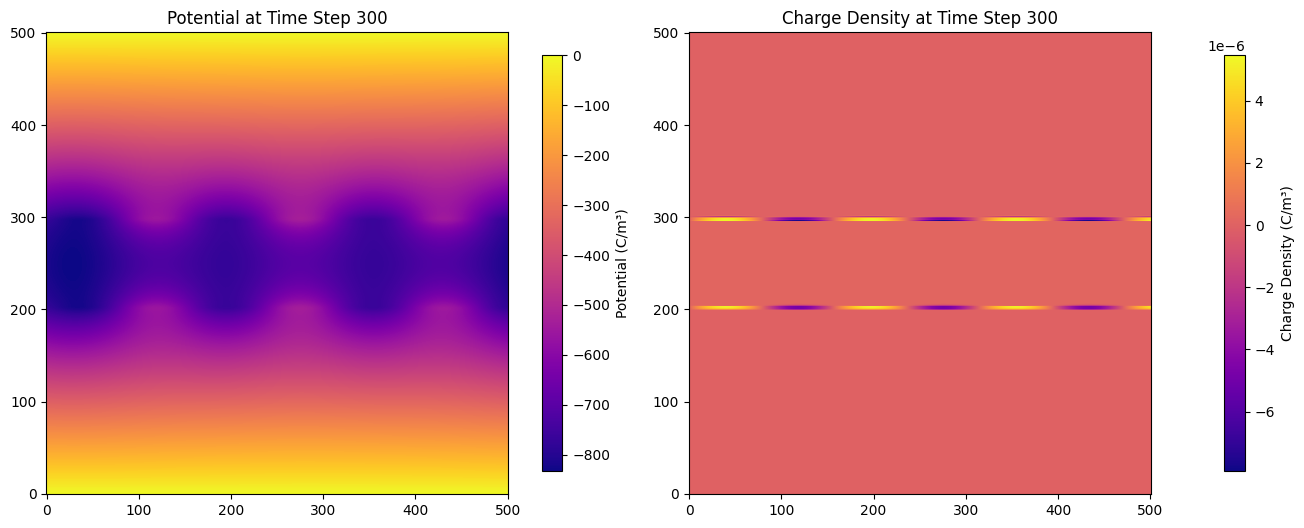

<Figure size 640x480 with 0 Axes>

Total charge = 0.007372834727562587
Total charge = 0.007368624770321559
Total charge = 0.0073644140313827685
Total charge = 0.007360202506215416
Total charge = 0.00735599019027634
Total charge = 0.007351777079009976
Total charge = 0.007347563167848298
Total charge = 0.007343348452210785
Total charge = 0.007339132927504367
Total charge = 0.007334916589123378
Total charge = 0.007330699432449515
Total charge = 0.007326481452851786
Total charge = 0.007322262645686465
Total charge = 0.007318043006297048
Total charge = 0.007313822530014201
Total charge = 0.007309601212155721
Total charge = 0.00730537904802648
Total charge = 0.007301156032918389
Total charge = 0.007296932162110341
Total charge = 0.007292707430868172
Total charge = 0.007288481834444608
Total charge = 0.00728425536807923
Total charge = 0.007280028026998408
Total charge = 0.007275799806415274
Total charge = 0.007271570701529665
Total charge = 0.007267340707528076
Total charge = 0.007263109819583618
Total charge = 0.0072588780328

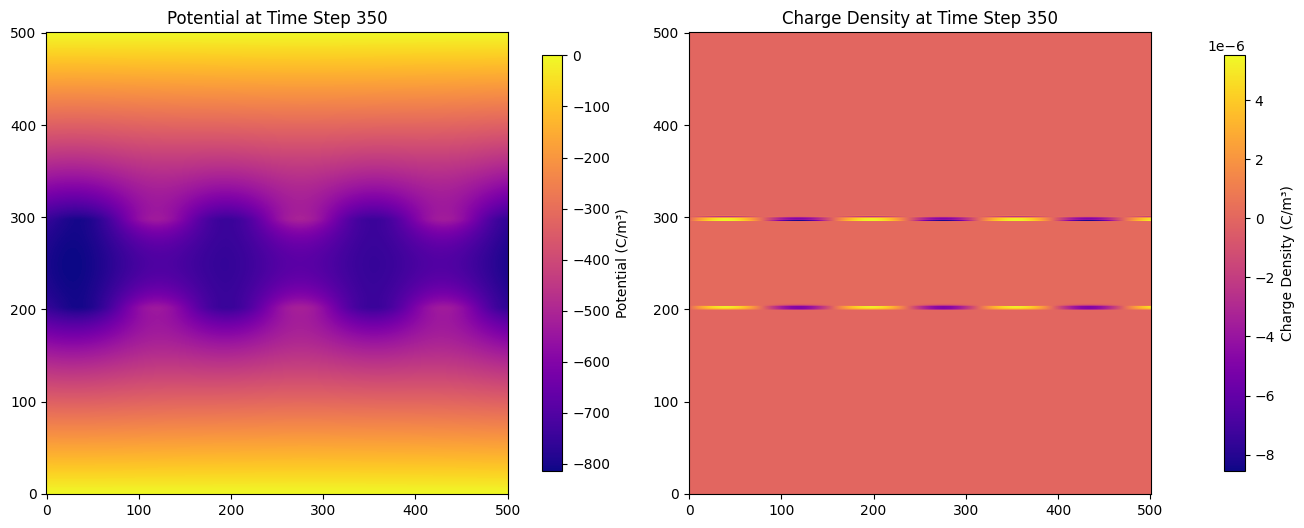

<Figure size 640x480 with 0 Axes>

Total charge = 0.007161287536617107
Total charge = 0.00715703269124953
Total charge = 0.007152776821588208
Total charge = 0.007148519922427153
Total charge = 0.00714426198854568
Total charge = 0.007140003014708359
Total charge = 0.007135742995664976
Total charge = 0.007131481926150476
Total charge = 0.007127219800884929
Total charge = 0.007122956614573469
Total charge = 0.007118692361906257
Total charge = 0.007114427037558433
Total charge = 0.007110160636190066
Total charge = 0.007105893152446108
Total charge = 0.00710162458095635
Total charge = 0.007097354916335375
Total charge = 0.007093084153182505
Total charge = 0.007088812286081766
Total charge = 0.007084539309601829
Total charge = 0.007080265218295971
Total charge = 0.007075990006702027
Total charge = 0.007071713669342338
Total charge = 0.007067436200723714
Total charge = 0.007063157595337381
Total charge = 0.007058877847658935
Total charge = 0.007054596952148294
Total charge = 0.007050314903249655
Total charge = 0.00704603169539

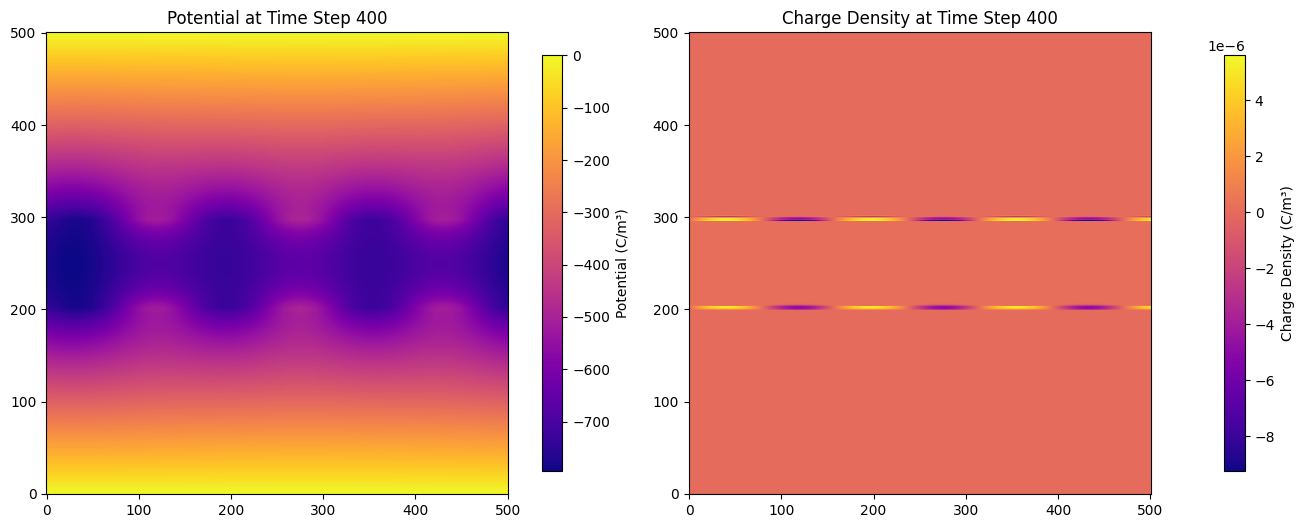

<Figure size 640x480 with 0 Axes>

Total charge = 0.006947184987679419
Total charge = 0.006942872251501702
Total charge = 0.006938558211813841
Total charge = 0.0069342428626179235
Total charge = 0.006929926197899017
Total charge = 0.006925608211625113
Total charge = 0.006921288897747093
Total charge = 0.0069169682501986724
Total charge = 0.006912646262896356
Total charge = 0.006908322929739397
Total charge = 0.0069039982446097445
Total charge = 0.006899672201372
Total charge = 0.006895344793873371
Total charge = 0.006891016015943628
Total charge = 0.0068866858613950525
Total charge = 0.0068823543240223925
Total charge = 0.006878021397602824
Total charge = 0.006873687075895892
Total charge = 0.0068693513526434736
Total charge = 0.006865014221569732
Total charge = 0.006860675676381064
Total charge = 0.006856335710766063
Total charge = 0.006851994318395463
Total charge = 0.0068476514929221004
Total charge = 0.0068433072279808676
Total charge = 0.00683896151718866
Total charge = 0.006834614354144339
Total charge = 0.0068302

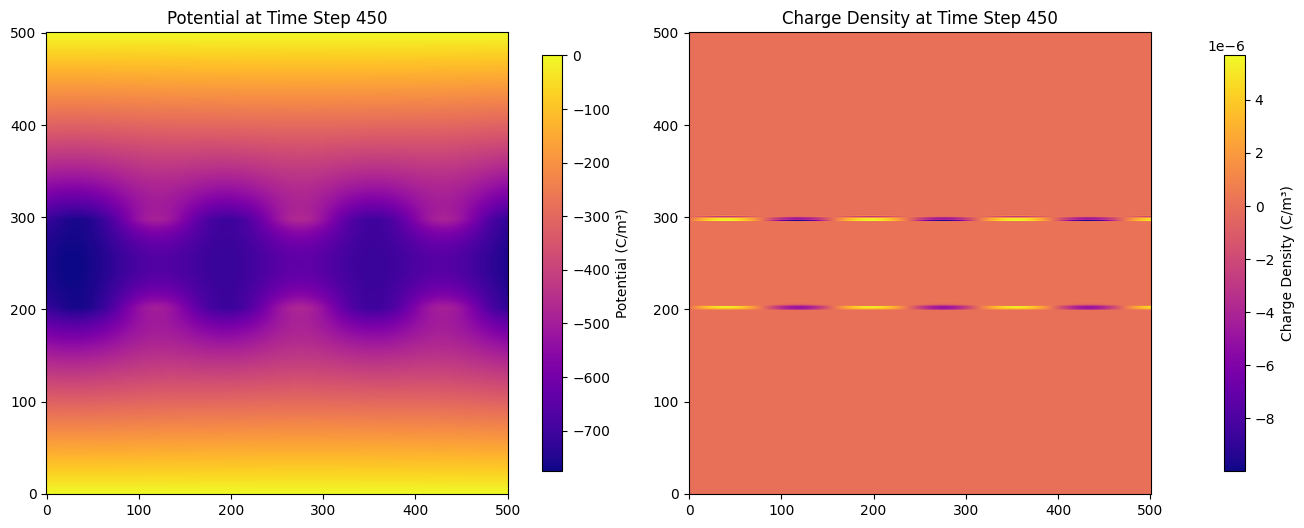

<Figure size 640x480 with 0 Axes>

Total charge = 0.006729829801422003
Total charge = 0.006725444198007233
Total charge = 0.006721056969429695
Total charge = 0.00671666810878397
Total charge = 0.006712277609145326
Total charge = 0.0067078854635696725
Total charge = 0.006703491665093517
Total charge = 0.006699096206733917
Total charge = 0.006694699081488438
Total charge = 0.0066903002823351055
Total charge = 0.006685899802232361
Total charge = 0.006681497634119018
Total charge = 0.006677093770914215
Total charge = 0.006672688205517373
Total charge = 0.006668280930808146
Total charge = 0.006663871939646384
Total charge = 0.006659461224872081
Total charge = 0.006655048779305329
Total charge = 0.006650634595746282
Total charge = 0.0066462186669751025
Total charge = 0.00664180098575192
Total charge = 0.006637381544816786
Total charge = 0.00663296033688963
Total charge = 0.006628537354670214
Total charge = 0.006624112590838084
Total charge = 0.0066196860380525364
Total charge = 0.0066152576889525585
Total charge = 0.006610827

In [ ]:
#run simulation
rho = np.zeros([nx+1,ny+1],float)
rho[200:300,:] = 1e12* (1.6e-19) #C/m^2
rho[290:300,:] = 1e12* (1.6e-19) + 8e-7 *np.sin(0.04*x)
rho[200:210,:] = 1e12* (1.6e-19) + 8e-7 *np.sin(0.04*x)

dt = 1e-10

plt.imshow(rho, origin = 'lower')
plt.colorbar(label="Charge Density (C/m^2)",shrink=0.8)

step = 500
for i in range (step):
    
    phi = solve_poisson_1(rho)
    Ex, Ey = electric_field(phi)
    vx, vy = velocity(Ex, Ey, B)
    rho_new = forward_euler_charge_density(rho,vx,vy,dt)
    #rho_new = fast_fourier_transform_rho(rho,vx,vy,dt)
    #rho_new = solve_rho_ode(vx,vy,rho)
    rho =  rho_new
    print(f"Total charge = {np.sum(rho)}")
    #rho = np.sum(rho_new)


    if i % 50 == 0:
        print(f"Time step {i}")
        fig = plt.figure(figsize=(19, 6))
        ax1 = fig.add_subplot(1, 1, 1)
        plot_1 = ax1.imshow(rho_new, origin = 'lower',cmap = 'plasma')
        ax1.set_title(f"Charge Density at Time Step {i}")
        fig.colorbar(plot_1, ax=ax1, label='Charge Density (C/m³)', shrink=0.9)
        
        ax2 = fig.add_subplot(1, 2, 1)
        plot_2 = ax2.imshow(phi, origin = 'lower',cmap = 'plasma')
        ax2.set_title(f"Potential at Time Step {i}")
        fig.colorbar(plot_2, ax=ax2, label='Potential (C/m³)', shrink=0.9)
        #ax2.streamplot(X, Y, Ex, Ey, color="white", linewidth=1, cmap=plt.cm.inferno,
         #     density=1.5, arrowstyle='->', arrowsize=1.5)

        plt.show()
        plt.tight_layout()

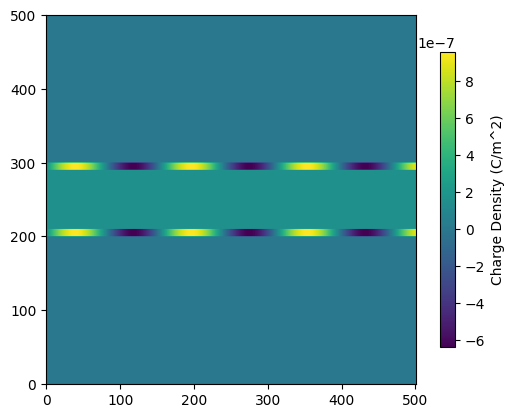

Time step 0
Total charge = 0.008259671123679872


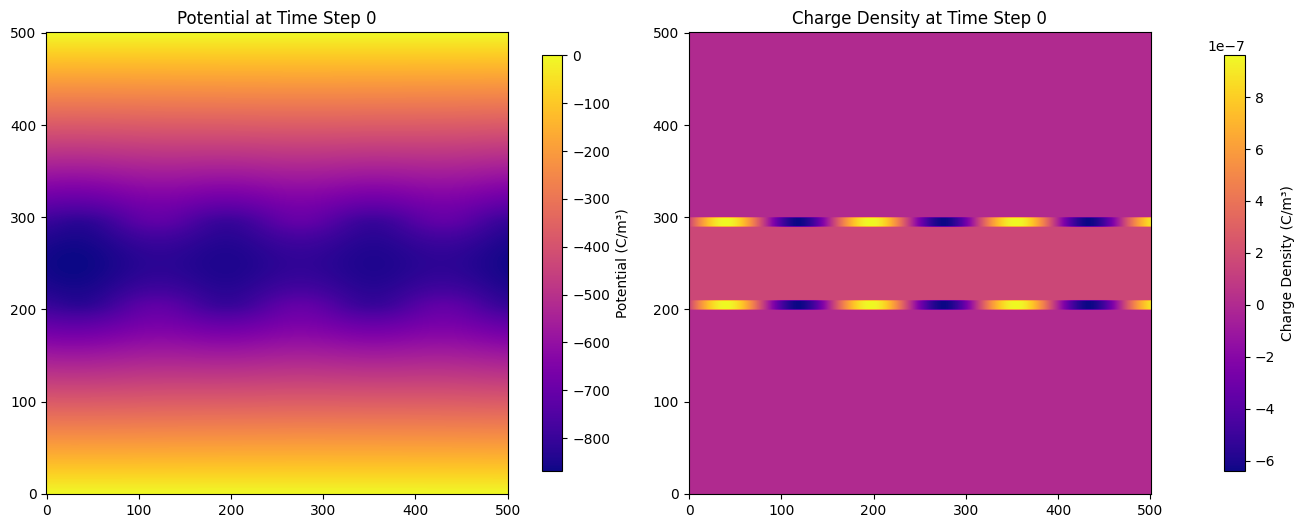

<Figure size 640x480 with 0 Axes>

Time step 100
Total charge = 0.008222925904719899


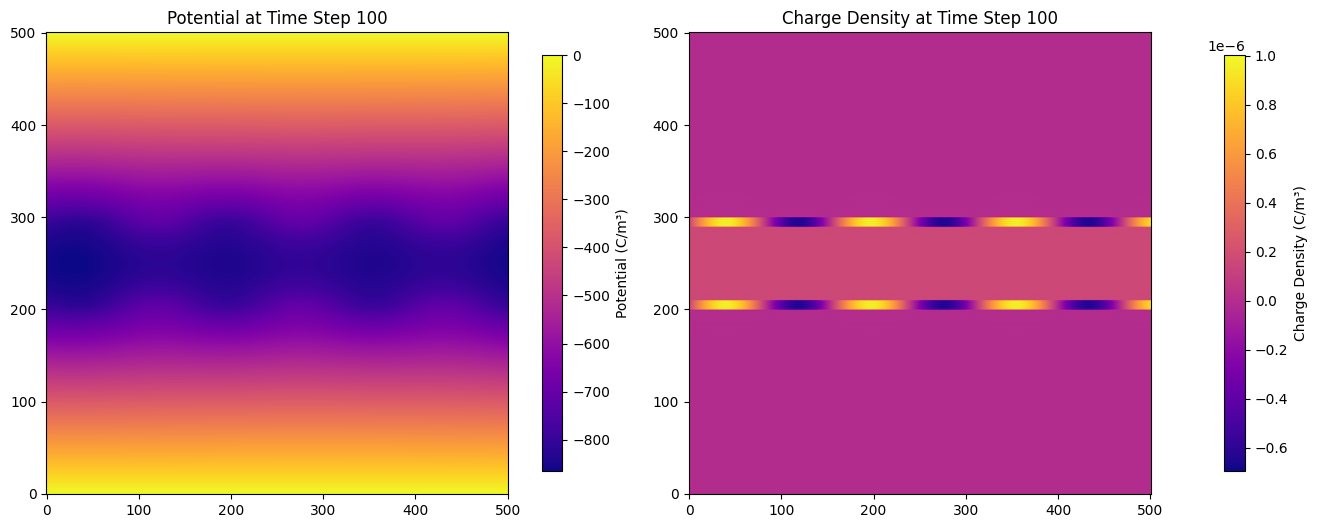

<Figure size 640x480 with 0 Axes>

Time step 200
Total charge = 0.008186298589896982


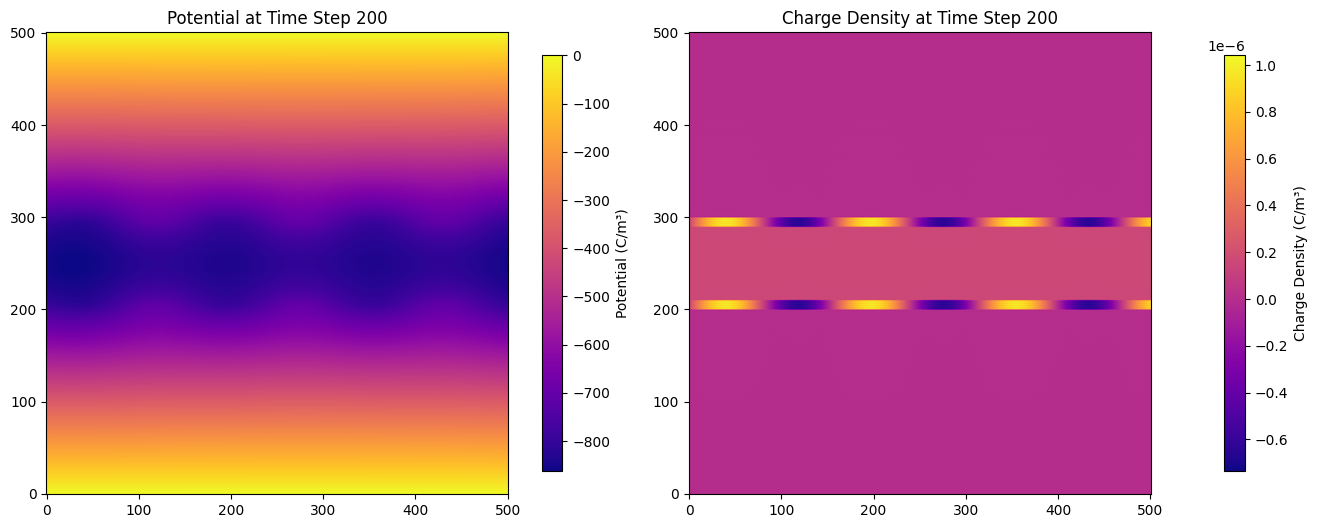

<Figure size 640x480 with 0 Axes>

Time step 300
Total charge = 0.008149789756267303


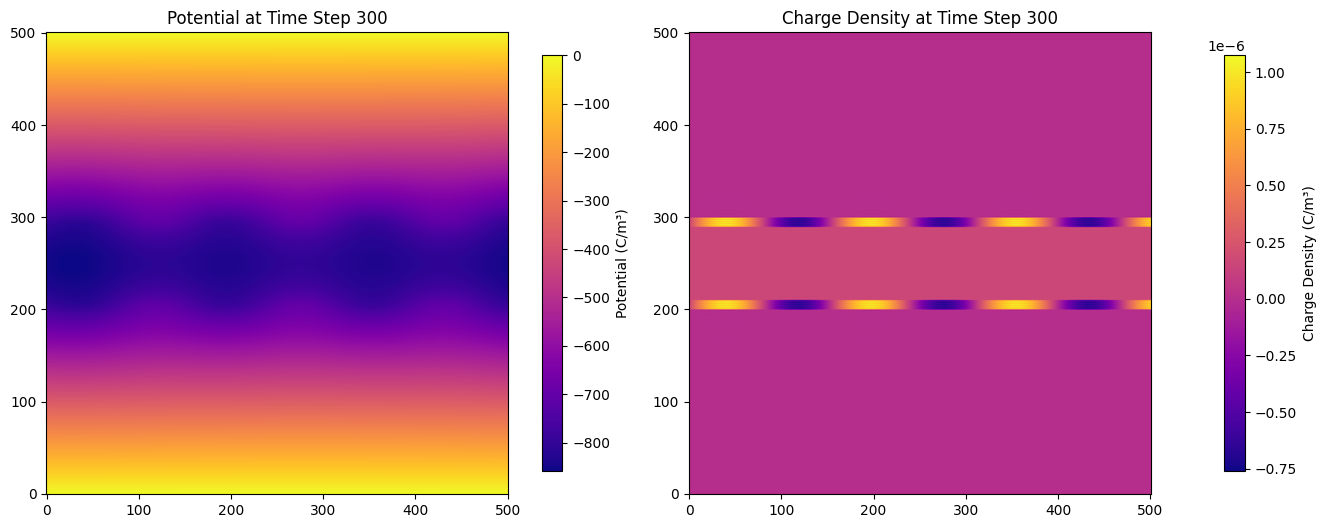

<Figure size 640x480 with 0 Axes>

Time step 400
Total charge = 0.00811339916931734


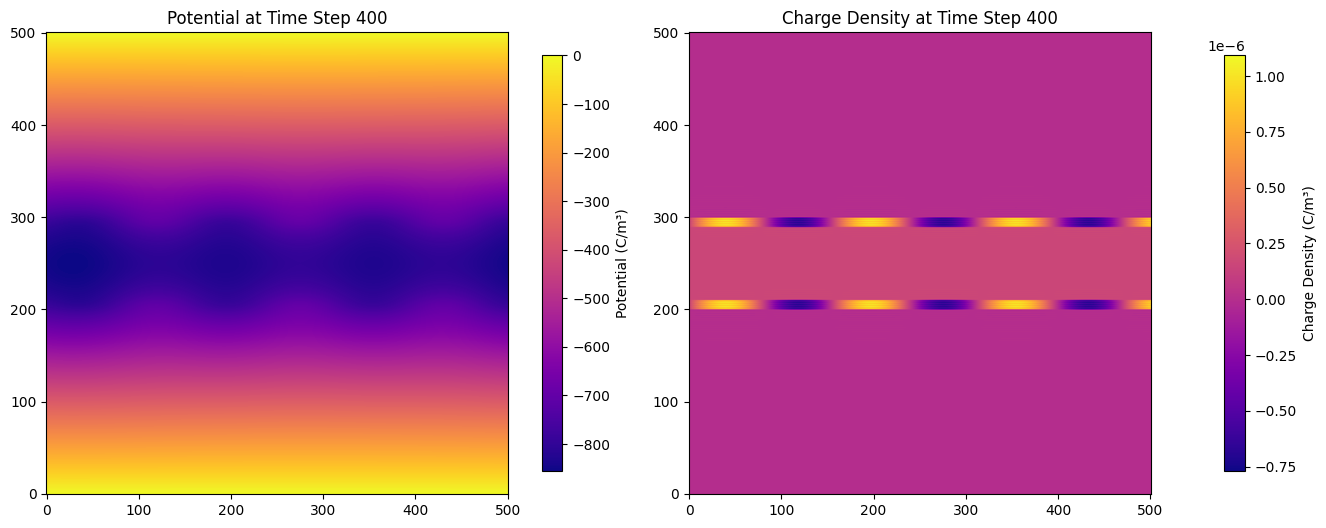

<Figure size 640x480 with 0 Axes>

In [ ]:
#run simulation

rho = np.zeros([nx+1,ny+1],float)
rho[200:300,:] = 1e12* (1.6e-19) #C/m^2
rho[290:300,:] = 1e12* (1.6e-19) + 8e-7 *np.sin(0.04*x)
rho[200:210,:] = 1e12* (1.6e-19) + 8e-7 *np.sin(0.04*x)

plt.imshow(rho, origin = 'lower')
plt.colorbar(label="Charge Density (C/m^2)",shrink=0.8)
dt = 1e-10
step = 500
for i in range (step):
    
    phi = solve_poisson_1(rho)
    Ex, Ey = electric_field(phi)
    vx, vy = velocity(Ex, Ey, B)
    #rho_new = forward_euler_charge_density(rho,vx,vy,dt)
    rho_new = fast_fourier_transform_rho(rho,vx,vy,dt)
    #rho_new = solve_rho_ode(vx,vy,rho)
    rho =  rho_new
    #rho = np.sum(rho_new)


    if i % 100 == 0:
        print(f"Time step {i}")
        print(f"Total charge = {np.sum(rho)}")

        fig = plt.figure(figsize=(19, 6))
        ax1 = fig.add_subplot(1, 1, 1)
        plot_1 = ax1.imshow(rho_new, origin = 'lower',cmap = 'plasma')
        ax1.set_title(f"Charge Density at Time Step {i}")
        fig.colorbar(plot_1, ax=ax1, label='Charge Density (C/m³)', shrink=0.9)
        
        ax2 = fig.add_subplot(1, 2, 1)
        plot_2 = ax2.imshow(phi, origin = 'lower',cmap = 'plasma')
        ax2.set_title(f"Potential at Time Step {i}")
        fig.colorbar(plot_2, ax=ax2, label='Potential (C/m³)', shrink=0.9)
        #ax2.streamplot(X, Y, Ex, Ey, color="white", linewidth=1, cmap=plt.cm.inferno,
         #     density=1.5, arrowstyle='->', arrowsize=1.5)

        plt.show()
        plt.tight_layout()